In [8]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from gnn.models import GINModel

from gnn.dgldataset import HandGestureGraphDataset
from gnn.dataloader import HandGestureDataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline


dataset/asl_dataset/0
dataset/asl_dataset/1
dataset/asl_dataset/2
dataset/asl_dataset/3
dataset/asl_dataset/4
dataset/asl_dataset/5
dataset/asl_dataset/6
dataset/asl_dataset/7
dataset/asl_dataset/8
dataset/asl_dataset/9
dataset/asl_dataset/a
dataset/asl_dataset/b
dataset/asl_dataset/c
dataset/asl_dataset/d
dataset/asl_dataset/e
dataset/asl_dataset/f
dataset/asl_dataset/g
dataset/asl_dataset/h
dataset/asl_dataset/i
dataset/asl_dataset/j
dataset/asl_dataset/k
dataset/asl_dataset/l
dataset/asl_dataset/m
dataset/asl_dataset/n
dataset/asl_dataset/o
dataset/asl_dataset/p
dataset/asl_dataset/q
dataset/asl_dataset/r
dataset/asl_dataset/s
dataset/asl_dataset/t
dataset/asl_dataset/u
dataset/asl_dataset/v
dataset/asl_dataset/w
dataset/asl_dataset/x
dataset/asl_dataset/y
dataset/asl_dataset/z


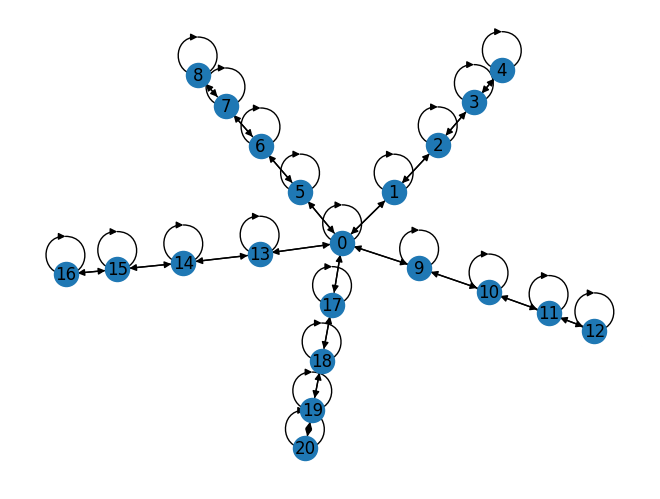

In [2]:
import networkx as nx

# Create the dgl dataset
hand_gesture_dataset = HandGestureGraphDataset()

# Define data loader
hand_gesture_dataloader = HandGestureDataLoader(dataset=hand_gesture_dataset, test_split=0.3, val_split=0.1)
train_loader = hand_gesture_dataloader.get_train_loader()
test_loader = hand_gesture_dataloader.get_test_loader()
val_loader = hand_gesture_dataloader.get_val_loader()

num_node_feature_dim = hand_gesture_dataset.num_node_feature_dim      # Get the number of features for each node - 3
num_classes = hand_gesture_dataset.num_classes                  # Get the number of classes - 36

g = hand_gesture_dataset[0][0]
nx_g = g.to_networkx()

# Plot using NetworkX
nx.draw(nx_g, with_labels=True)

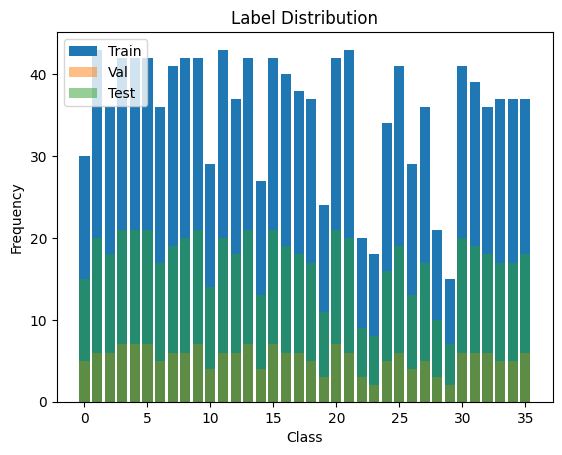

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get the one-hot encoded labels for train, val, and test sets
train_labels = np.vstack([labels.numpy() for _, labels in train_loader])
val_labels = np.vstack([labels.numpy() for _, labels in val_loader])
test_labels = np.vstack([labels.numpy() for _, labels in test_loader])

# Calculate the frequency of each class in the train, val, and test sets
train_class_freq = train_labels.sum(axis=0)
val_class_freq = val_labels.sum(axis=0)
test_class_freq = test_labels.sum(axis=0)

# Plot the label distribution
fig, ax = plt.subplots()
ax.bar(np.arange(num_classes), train_class_freq, label='Train')
ax.bar(np.arange(num_classes), val_class_freq, label='Val', alpha=0.5)
ax.bar(np.arange(num_classes), test_class_freq, label='Test', alpha=0.5)
ax.legend()
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Label Distribution')
plt.show()

In [9]:
def draw_plot(train_losses, val_losses, val_accs, train_accs):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Training Progress')

    axes[0].plot(train_losses, label='Training')
    axes[0].plot(val_losses, label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(val_accs, label='Validation')
    axes[1].plot(train_accs, label='Train')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()



def train(model, train_loader, val_loader, lr=0.01, epochs=20):
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs = []
    # Define optimizer and loss function
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = CrossEntropyLoss()

    # Train the model
    epochs = epochs

    for epoch in range(epochs):
        # Set model to the train mode
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        # Train on batches
        for batch_idx, (bg, labels) in enumerate(train_loader):
            # Forward pass
            features = bg.ndata['feat']
            logits = model(bg, features)

            # print(logits.size(), labels.size())

            # Compute loss
            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            predicted = torch.argmax(logits, dim=1)
            true_labels = torch.argmax(labels, dim=1)
            total_train_correct += (predicted == true_labels).sum().item()
            total_train_samples += true_labels.shape[0]

        train_acc = total_train_correct / total_train_samples

        # Evaluate on validation set
        model.eval()
        total_val_loss = 0.0
        total_val_acc = 0.0
        with torch.no_grad():
            for batch_idx, (bg, labels) in enumerate(val_loader):
                # Forward pass
                features = bg.ndata['feat']
                logits = model(bg, features)

                # Compute loss
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                # Compute accuracy
                predicted = torch.argmax(logits, dim=1)
                true_labels = torch.argmax(labels, dim=1)
                # print(f'The predicted is: {predicted}, the true_label is: {true_labels}')
                # print(f'The correct number was: {(predicted == true_labels).sum()}, the number of all candidates is: {len(true_labels)}, the number of val_loader is: {len(val_loader)}')
                total_val_acc += ((predicted == true_labels).sum()).item()

            avg_val_loss = total_val_loss / len(val_loader)
            avg_val_acc = total_val_acc / len(hand_gesture_dataloader.val_indices)

            # Print training and validation loss for the epoch
            print('Epoch {}, Train Accuracy {:.4f}, Train Loss {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}'.format(epoch, train_acc,
                                                                                             total_train_loss / len(
                                                                                                 train_loader),
                                                                                             avg_val_loss, avg_val_acc))

            val_losses.append(avg_val_loss)
            train_losses.append(total_train_loss / len(train_loader))
            val_accs.append(avg_val_acc)
            train_accs.append(train_acc)

    draw_plot(train_losses=train_losses, val_losses=val_losses, val_accs=val_accs, train_accs=train_accs)
    return model

In [10]:
def test(model, test_loader):
    criterion = CrossEntropyLoss()
    # Evaluate on test set
    model.eval()
    total_test_loss = 0.0
    total_test_acc = 0.0
    with torch.no_grad():
        for batch_idx, (bg, labels) in enumerate(test_loader):
            # Forward pass
            features = bg.ndata['feat']
            logits = model(bg, features)

            # Compute loss
            loss = criterion(logits, labels)
            total_test_loss += loss.item()

            # Compute accuracy
            predicted = torch.argmax(logits, dim=1)
            true_labels = torch.argmax(labels, dim=1)
            total_test_acc += ((predicted == true_labels).sum()).item()

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_acc / len(hand_gesture_dataloader.test_indices)

        print('Test Loss {:.4f}, Test Accuracy {:.4f}'.format(avg_test_loss, avg_test_acc))

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

GINModel(
  (ginlayers): ModuleList(
    (0): GINConv(
      (apply_func): MLP(
        (linears): ModuleList(
          (0): Linear(in_features=3, out_features=32, bias=False)
          (1): Linear(in_features=32, out_features=32, bias=False)
        )
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1-3): 3 x GINConv(
      (apply_func): MLP(
        (linears): ModuleList(
          (0-1): 2 x Linear(in_features=32, out_features=32, bias=False)
        )
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (batch_norms): ModuleList(
    (0-3): 4 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_prediction): ModuleList(
    (0): Linear(in_features=3, out_features=36, bias=True)
    (1-4): 4 x Linear(in_features=32, out_features=36, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (pool): SumPo

<Figure size 640x480 with 0 Axes>

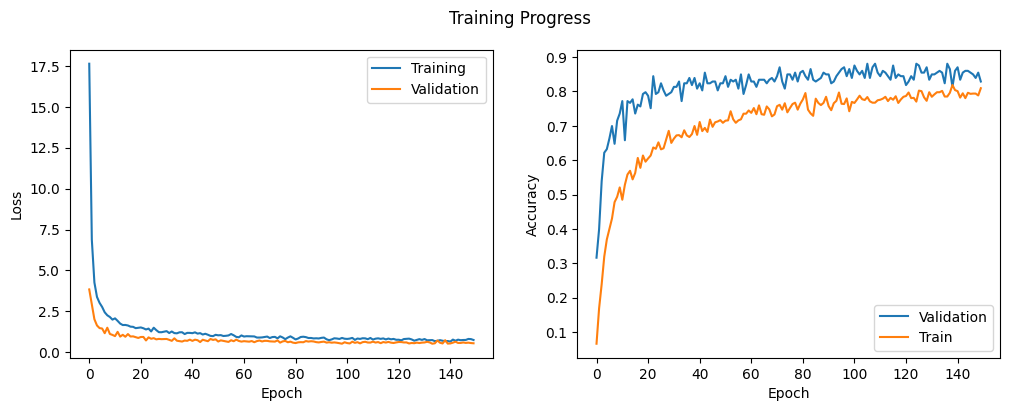

Test Loss 0.6102, Test Accuracy 0.8583


In [12]:
gin = GINModel(in_feats=num_node_feature_dim, n_hidden=32, out_dim=num_classes)
print(gin)
print(count_parameters(gin))
# Train the model
gin_trained_model = train(gin, train_loader, val_loader, lr=0.0005, epochs=150)
# Test the model
test(gin_trained_model, test_loader)

GATModel(
  (conv_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=3, out_features=96, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=3, out_features=96, bias=False)
    )
    (1-2): 2 x GATConv(
      (fc): Linear(in_features=96, out_features=96, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): GATConv(
      (fc): Linear(in_features=96, out_features=216, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (bn_layers): ModuleList(
    (0-2): 3 x BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(36, eps=1e-05, momentum=0.1, affi

<Figure size 640x480 with 0 Axes>

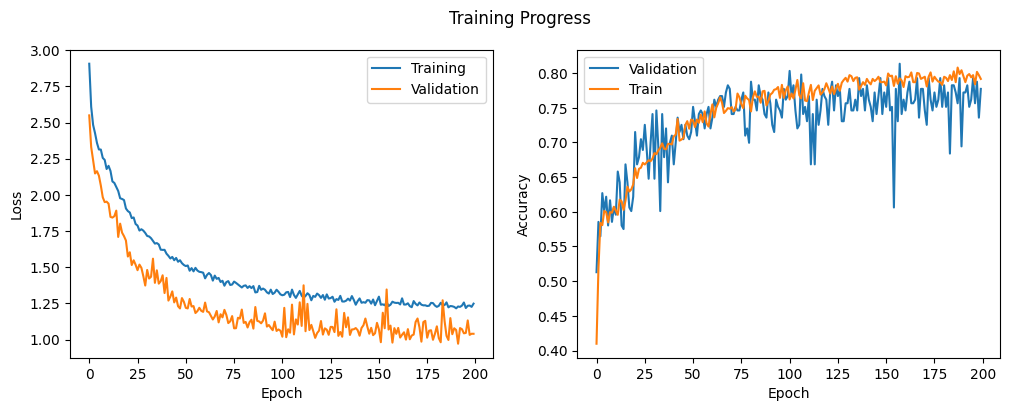

Test Loss 1.0244, Test Accuracy 0.7606


In [25]:
import dgl
import torch
from dgl.nn.pytorch import GATConv

class GATModel(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_heads, n_layers):
        super(GATModel, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.n_layers = n_layers

        self.conv_layers.append(GATConv(in_feats, hidden_feats, num_heads=num_heads, residual=True))
        self.bn_layers.append(nn.BatchNorm1d(hidden_feats * num_heads))

        for i in range(1, n_layers - 1):
            self.conv_layers.append(GATConv(hidden_feats * num_heads, hidden_feats, num_heads=num_heads))
            self.bn_layers.append(nn.BatchNorm1d(hidden_feats * num_heads))

        self.conv_layers.append(GATConv(hidden_feats * num_heads, out_feats, num_heads=6))
        self.bn_layers.append(nn.BatchNorm1d(out_feats))

    def forward(self, g, h):
        h = h

        for i in range(self.n_layers - 1):
            h = self.conv_layers[i](g, h).flatten(1)
            h = self.bn_layers[i](h)
            h = F.elu(h)

        h = self.conv_layers[self.n_layers - 1](g, h).mean(1)
        h = self.bn_layers[self.n_layers - 1](h)

        with g.local_scope():
            g.ndata['h'] = h
            hg = dgl.mean_nodes(g, 'h')
            return hg



gat = GATModel(in_feats= num_node_feature_dim, hidden_feats=32, out_feats=num_classes, num_heads=3, n_layers=4)
print(gat)
print(count_parameters(gat))
# Train the model
gat_trained_model = train(gat, train_loader, val_loader, lr=0.001, epochs=200)
# Test the model
test(gat_trained_model, test_loader)